<center><img src='../../img/ai4eo_logos.jpg' alt='Logos AI4EO MOOC' width='80%'></img></center>

<hr>

<br>

<a href="../00_index.ipynb"><< Index</a><br>
<a href="./"><< Placeholder 1</a><span style="float:right;"><a href="./">Placeholder 2 >></a></span>

# Reinforcement Learning

<i>by Carlos Fortuny-Lombraña, EUMETSAT, Darmstadt, Germany</i>

<hr>

## Watch the video tutorial

In [1]:
from IPython.display import HTML
HTML('<div align="center"><iframe src="https://player.vimeo.com/video/510225048" width="640" height="360" frameborder="0" allow="autoplay; fullscreen; picture-in-picture" allowfullscreen align="middle"></iframe></div>')     

<hr>

## Introduction

blablabla

## Data

blablabla

## Further Resources

blablabla

<hr>

## Notebook outline
* [1 - Example](#Example)

<hr>

#### Import libraries

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from __future__ import absolute_import
import pickle
import argparse
import numpy as np
import tensorflow.compat.v1 as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.disable_v2_behavior()
import skimage.io as io
import easydict
from skimage import img_as_ubyte
from IPython.display import Image, display

#### Load helper functions

In [3]:
%run ./A2RL-functions.ipynb

In [4]:
def vfn_rl(x, variable_dict, global_feature=None, h=None, c=None, embedding_dim=1000):
    ########################## VFN ##################################
    ######################## Layer 1 ################################
    ## conv1
    #  conv(11, 11, 96, 4, 4, padding='VALID', name='conv1')
    k_h = 11; k_w = 11; c_o = 96; s_h = 4; s_w = 4
    conv1W = variable_dict["c1w"]
    conv1b = variable_dict["c1b"]
    conv1_in = conv(x, conv1W, conv1b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=1)
    conv1 = tf.nn.relu(conv1_in)
    ## lrn1
    #  lrn(2, 2e-05, 0.75, name='norm1')
    radius = 2; alpha = 2e-05; beta = 0.75; bias = 1.0
    lrn1 = tf.nn.local_response_normalization(conv1,
                                              depth_radius=radius,
                                              alpha=alpha,
                                              beta=beta,
                                              bias=bias)
    ## maxpool1
    #  max_pool(3, 3, 2, 2, padding='VALID', name='pool1')
    k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
    maxpool1 = tf.nn.max_pool(lrn1, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)

    ######################## Layer 2 ################################
    ## conv2
    #  conv(5, 5, 256, 1, 1, group=2, name='conv2')
    k_h = 5; k_w = 5; c_o = 256; s_h = 1; s_w = 1; group = 2
    conv2W = variable_dict["c2w"]
    conv2b = variable_dict["c2b"]
    conv2_in = conv(maxpool1, conv2W, conv2b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    conv2 = tf.nn.relu(conv2_in)
    ## lrn2
    #  lrn(2, 2e-05, 0.75, name='norm2')
    radius = 2; alpha = 2e-05; beta = 0.75; bias = 1.0
    lrn2 = tf.nn.local_response_normalization(conv2,
                                              depth_radius=radius,
                                              alpha=alpha,
                                              beta=beta,
                                              bias=bias)
    ## maxpool2
    #  max_pool(3, 3, 2, 2, padding='VALID', name='pool2')
    k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
    maxpool2 = tf.nn.max_pool(lrn2, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)

    ######################## Layer 3 ################################
    ## conv3
    #  conv(3, 3, 384, 1, 1, name='conv3')
    k_h = 3; k_w = 3; c_o = 384; s_h = 1; s_w = 1; group = 1
    conv3W = variable_dict["c3w"]
    conv3b = variable_dict["c3b"]
    conv3_in = conv(maxpool2, conv3W, conv3b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    conv3 = tf.nn.relu(conv3_in)

    ######################## Layer 4 ################################
    ## conv4
    #  conv(3, 3, 384, 1, 1, group=2, name='conv4')
    k_h = 3; k_w = 3; c_o = 384; s_h = 1; s_w = 1; group = 2
    conv4W = variable_dict["c4w"]
    conv4b = variable_dict["c4b"]
    conv4_in = conv(conv3, conv4W, conv4b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    conv4 = tf.nn.relu(conv4_in)

    ######################## Layer 5 ################################
    ## conv5
    #  conv(3, 3, 256, 1, 1, group=2, name='conv5')
    k_h = 3; k_w = 3; c_o = 256; s_h = 1; s_w = 1; group = 2
    conv5W = variable_dict["c5w"]
    conv5b = variable_dict["c5b"]
    conv5_in = conv(conv4, conv5W, conv5b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    conv5 = tf.nn.relu(conv5_in)
    ## maxpool5
    #  max_pool(3, 3, 2, 2, padding='VALID', name='pool5')
    with tf.variable_scope("conv5"):
        k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
        maxpool5 = tf.nn.max_pool(conv5, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)
        bn5 = keras.layers.Flatten()(maxpool5)

    ####################### Layer 6 ################################
    fc6W =  variable_dict["fc6w"]
    fc6b = variable_dict["fc6b"]
    fc6 = tf.nn.relu_layer(bn5, fc6W, fc6b)

    if global_feature is None:
        return fc6

    ########################### RL ##################################
    x_rl = tf.concat([global_feature, fc6], axis=1)
    ############## Layer 1 #################
    fc1W = variable_dict['fc1.weight'].T
    fc1b = variable_dict['fc1.bias']
    fc1 = tf.nn.relu_layer(x_rl, fc1W, fc1b)

    ############## Layer 2 #################
    fc2W = variable_dict['fc2.weight'].T
    fc2b = variable_dict['fc2.bias']
    fc2 = tf.nn.relu_layer(fc1, fc2W, fc2b)

    ############## Layer 3 #################
    fc3W = variable_dict['fc3.weight'].T
    fc3b = variable_dict['fc3.bias']
    fc3 = tf.nn.relu_layer(fc2, fc3W, fc3b)

    ############## LSTM #################
    W = tf.matmul(fc3, variable_dict['lstm.weight_ih'].T) + variable_dict['lstm.bias_ih'] +\
        tf.matmul(h, variable_dict['lstm.weight_hh'].T) + variable_dict['lstm.bias_hh']
    i, f, g, o = tf.split(W, 4, axis=1)
    i = tf.sigmoid(i); f = tf.sigmoid(f); g = tf.tanh(g); o = tf.sigmoid(o);
    c = f*c + i*g
    h = o*tf.tanh(c)

    ############## Action #################
    action1w = variable_dict['action_fc.weight'].T
    action1b = variable_dict['action_fc.bias']
    action = tf.multinomial(tf.matmul(h, action1w) + action1b, 1)

    return action, h, c

In [5]:
def auto_cropping(origin_image):
    batch_size = len(origin_image)

    terminals = np.zeros(batch_size)
    ratios = np.repeat([[0, 0, 20, 20]], batch_size, axis=0)
    img = crop_input(origin_image, generate_bbox(origin_image, ratios))

    global_feature = sess.run(global_feature_placeholder, feed_dict={image_placeholder: img})
    h_np = np.zeros([batch_size, 1024])
    c_np = np.zeros([batch_size, 1024])
    
    while True:
        action_np, h_np, c_np = sess.run((action, h, c), feed_dict={image_placeholder: img,
                                                                    global_feature_placeholder: global_feature,
                                                                    h_placeholder: h_np,
                                                                    c_placeholder: c_np})
        ratios, terminals = command2action(action_np, ratios, terminals)
        #print(np.sum(terminals),batch_size)
        bbox = generate_bbox(origin_image, ratios)
        if np.sum(terminals) == batch_size:
            return bbox
        
        img = crop_input(origin_image, bbox)  

#### Main

In [6]:
global_dtype = tf.float32

with open('vfn_rl.pkl', 'rb') as f:
    var_dict = pickle.load(f)

image_placeholder = tf.placeholder(dtype=global_dtype, shape=[None,227,227,3])
global_feature_placeholder = vfn_rl(image_placeholder, var_dict)

h_placeholder = tf.placeholder(dtype=global_dtype, shape=[None,1024])
c_placeholder = tf.placeholder(dtype=global_dtype, shape=[None,1024])
action, h, c = vfn_rl(image_placeholder, var_dict, global_feature=global_feature_placeholder,
                                                           h=h_placeholder, c=c_placeholder)


# Generic Example

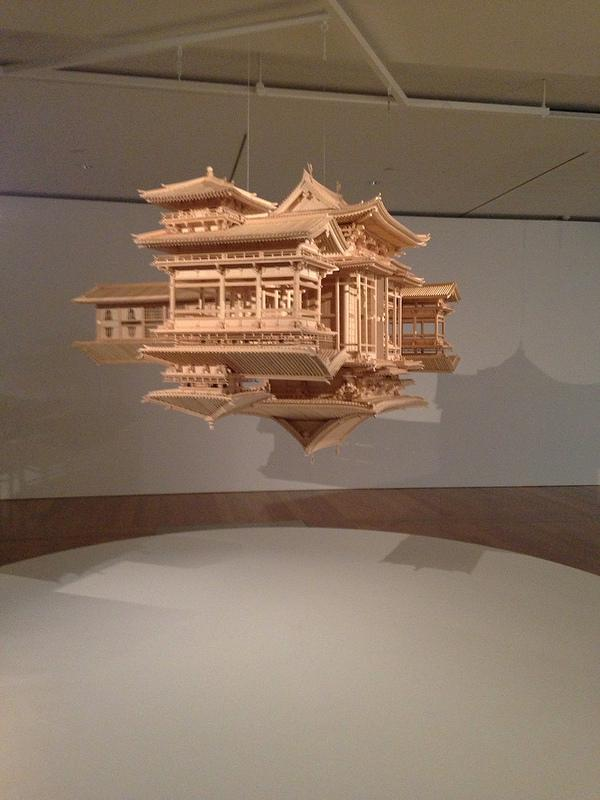

In [7]:
display(Image(filename='test_images/9036.jpg'))

**Iteration 1**

In [8]:
image_path = './test_images/9036.jpg'
save_path = './test_images/9036-1.jpg'

sess = tf.Session() 

args = easydict.EasyDict({
        "image_path": image_path,
        "save_path": save_path
})

im = io.imread(args.image_path).astype(np.float32) / 255
xmin, ymin, xmax, ymax = auto_cropping([im - 0.5])[0]
io.imsave(args.save_path, img_as_ubyte(im[ymin:ymax, xmin:xmax]))

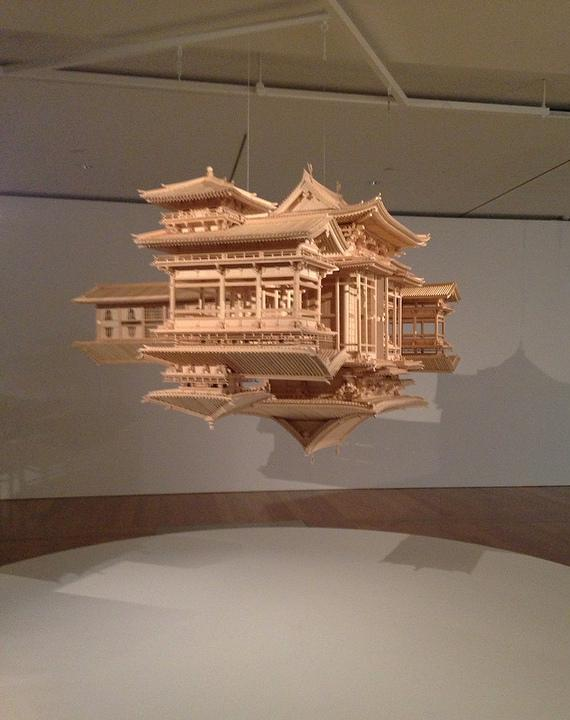

In [9]:
display(Image(filename='test_images/9036-1.jpg'))

**Iteration 2**

In [10]:
image_path = './test_images/9036-1.jpg'
save_path = './test_images/9036-2.jpg'

sess = tf.Session() 

args = easydict.EasyDict({
        "image_path": image_path,
        "save_path": save_path
})

im = io.imread(args.image_path).astype(np.float32) / 255
xmin, ymin, xmax, ymax = auto_cropping([im - 0.5])[0]
io.imsave(args.save_path, img_as_ubyte(im[ymin:ymax, xmin:xmax]))

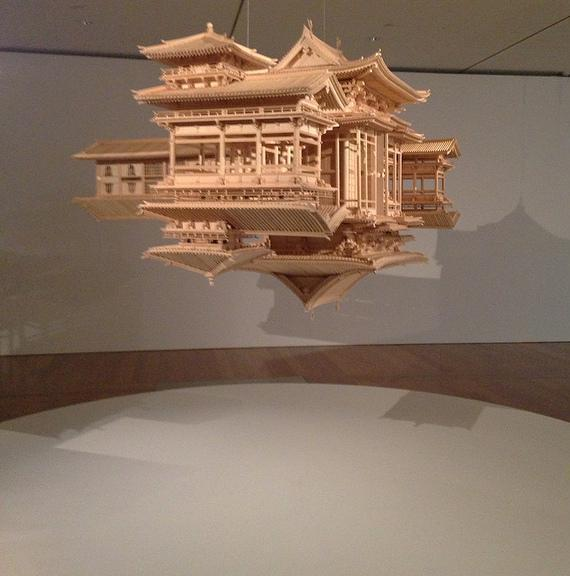

In [11]:
display(Image(filename='test_images/9036-2.jpg'))

**Iteration 3**

In [12]:
image_path = './test_images/9036-2.jpg'
save_path = './test_images/9036-3.jpg'

sess = tf.Session() 

args = easydict.EasyDict({
        "image_path": image_path,
        "save_path": save_path
})

im = io.imread(args.image_path).astype(np.float32) / 255
xmin, ymin, xmax, ymax = auto_cropping([im - 0.5])[0]
io.imsave(args.save_path, img_as_ubyte(im[ymin:ymax, xmin:xmax]))

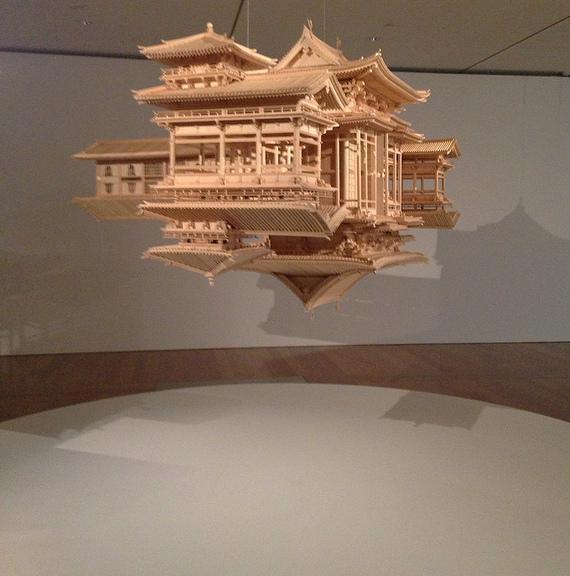

In [13]:
display(Image(filename='test_images/9036-3.jpg'))

**Iteration 4**

In [14]:
image_path = './test_images/9036-3.jpg'
save_path = './test_images/9036-4.jpg'

sess = tf.Session() 

args = easydict.EasyDict({
        "image_path": image_path,
        "save_path": save_path
})

im = io.imread(args.image_path).astype(np.float32) / 255
xmin, ymin, xmax, ymax = auto_cropping([im - 0.5])[0]
io.imsave(args.save_path, img_as_ubyte(im[ymin:ymax, xmin:xmax]))

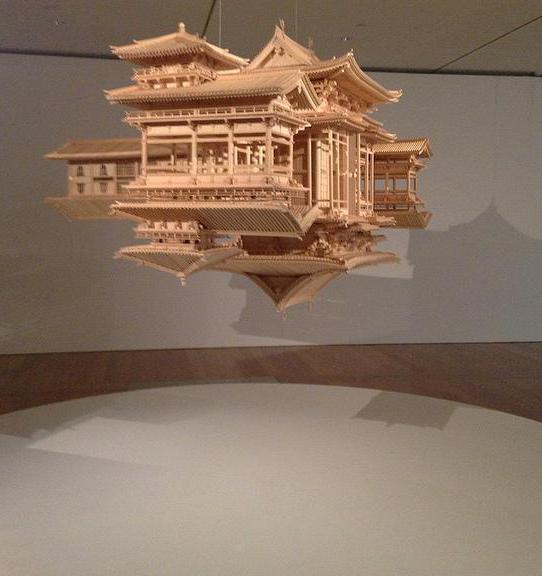

In [15]:
display(Image(filename='test_images/9036-4.jpg'))

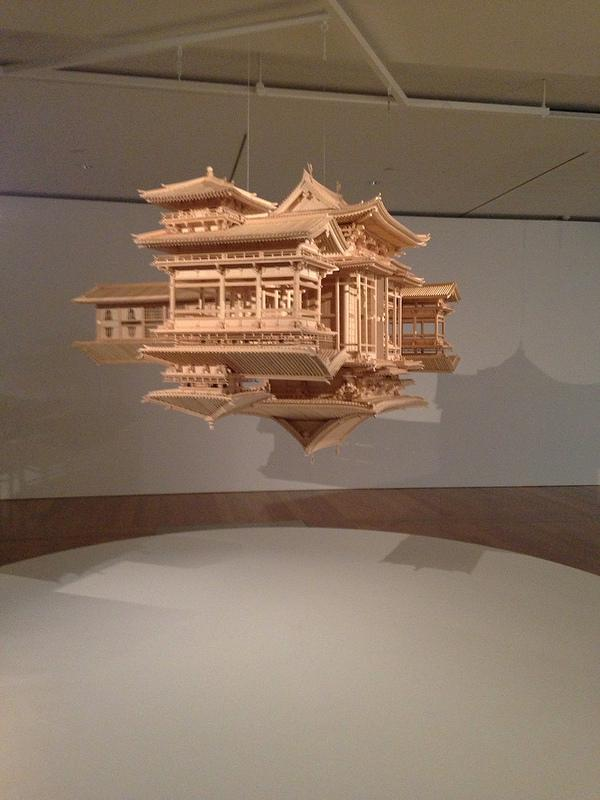

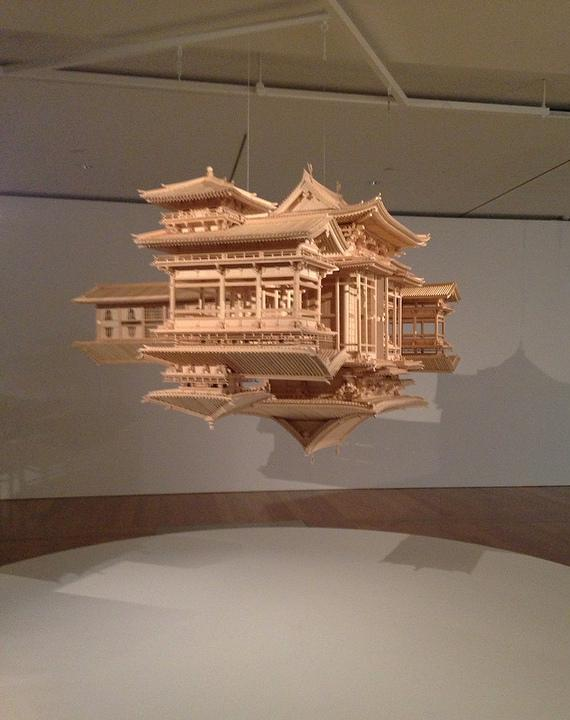

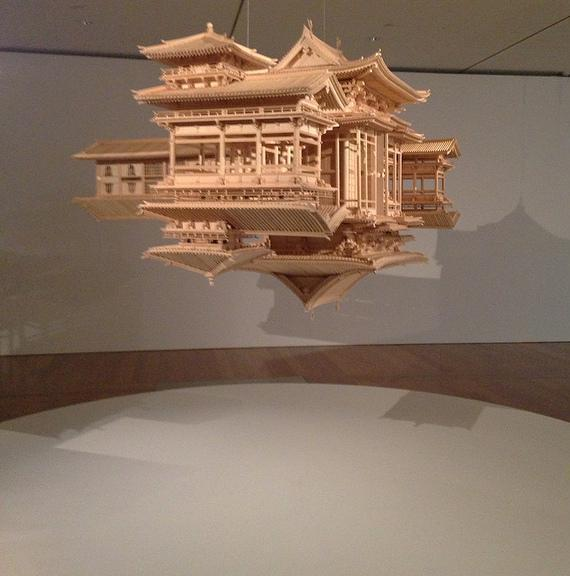

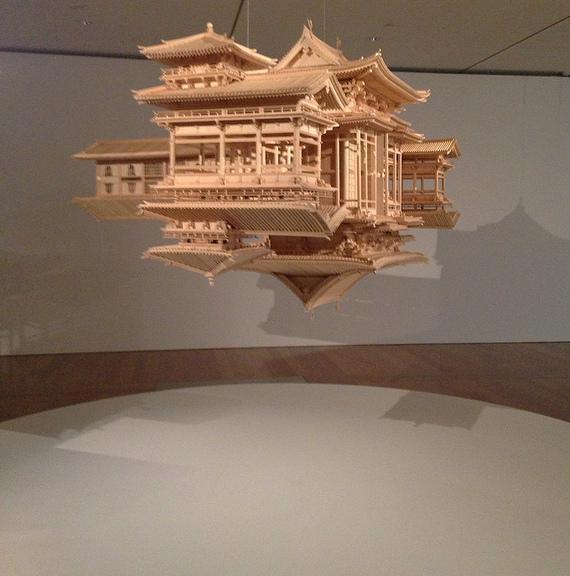

In [16]:
display(Image(filename='test_images/9036.jpg'))
display(Image(filename='test_images/9036-1.jpg'))
display(Image(filename='test_images/9036-2.jpg'))
display(Image(filename='test_images/9036-3.jpg'))

# Example with an Aerial Imagery from Sentinel-2 over a Greek Island (Atokos)

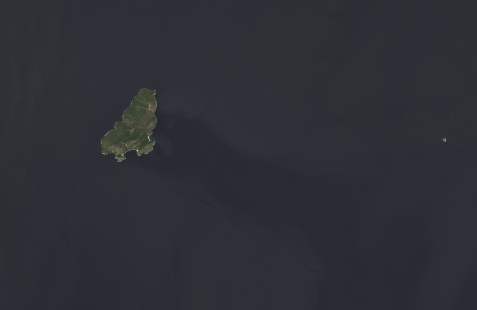

In [25]:
display(Image(filename='test_images/GreekIsland07-27-2018.png'))

**Iteration 1**

In [26]:
image_path = './test_images/GreekIsland07-27-2018.png'
save_path = './test_images/GreekIsland07-27-2018-1.png'

sess = tf.Session() 

args = easydict.EasyDict({
        "image_path": image_path,
        "save_path": save_path
})

im = io.imread(args.image_path).astype(np.float32) / 255
xmin, ymin, xmax, ymax = auto_cropping([im - 0.5])[0]
io.imsave(args.save_path, img_as_ubyte(im[ymin:ymax, xmin:xmax]))

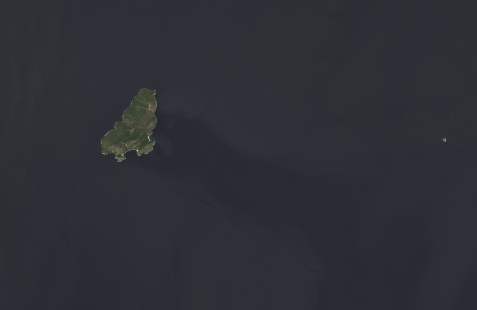

In [27]:
display(Image(filename='test_images/GreekIsland07-27-2018-1.png'))

**Iteration 2**

In [28]:
image_path = './test_images/GreekIsland07-27-2018-1.png'
save_path = './test_images/GreekIsland07-27-2018-2.png'

sess = tf.Session() 

args = easydict.EasyDict({
        "image_path": image_path,
        "save_path": save_path
})

im = io.imread(args.image_path).astype(np.float32) / 255
xmin, ymin, xmax, ymax = auto_cropping([im - 0.5])[0]
io.imsave(args.save_path, img_as_ubyte(im[ymin:ymax, xmin:xmax]))

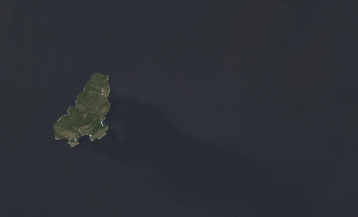

In [29]:
display(Image(filename='test_images/GreekIsland07-27-2018-2.png'))

**Iteration 3**

In [30]:
image_path = './test_images/GreekIsland07-27-2018-2.png'
save_path = './test_images/GreekIsland07-27-2018-3.png'

sess = tf.Session() 

args = easydict.EasyDict({
        "image_path": image_path,
        "save_path": save_path
})

im = io.imread(args.image_path).astype(np.float32) / 255
xmin, ymin, xmax, ymax = auto_cropping([im - 0.5])[0]
io.imsave(args.save_path, img_as_ubyte(im[ymin:ymax, xmin:xmax]))

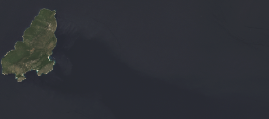

In [31]:
display(Image(filename='test_images/GreekIsland07-27-2018-3.png'))

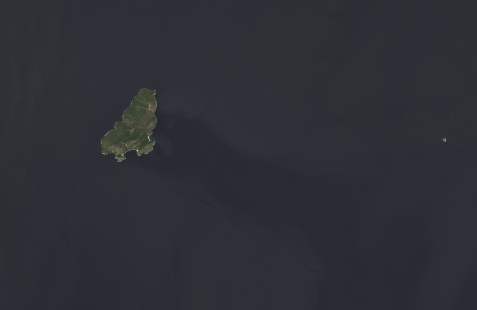

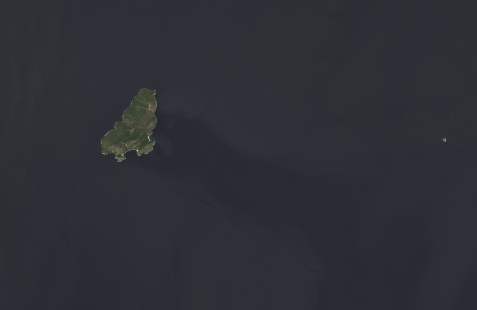

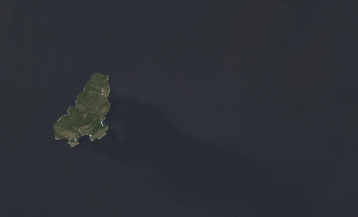

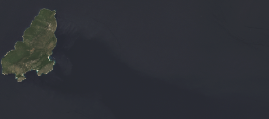

In [32]:
display(Image(filename='test_images/GreekIsland07-27-2018.png'))
display(Image(filename='test_images/GreekIsland07-27-2018-1.png'))
display(Image(filename='test_images/GreekIsland07-27-2018-2.png'))
display(Image(filename='test_images/GreekIsland07-27-2018-3.png'))